## Test the MIRI LRS distortion solution (standalone and JWST pipeline versions)  ##

### Set basic environment stuff ###

In [1]:
import os as os
import numpy as np
from numpy.testing import assert_allclose
import pdb as pdb
import pysiaf

siaf = pysiaf.Siaf('MIRI')

Import the MIRI coordinates code from https://github.com/STScI-MIRI/miricoord and ensure that it is on the PYTHONPATH.  Also ensure that the local data directory environmental variable is set:

setenv MIRICOORD_DATA_DIR /YourLocalPathToData/ (this is where io will happen)

In [2]:
data_dir=os.path.expandvars('$MIRICOORD_DATA_DIR')

### First we'll test the standalone distortion solution (lrs_tools) ###

In [3]:
import miricoord.miricoord.lrs.lrs_tools as lt

In [4]:
# If we wanted to set to the CDP-7beta3 version (i.e., use the cdp7b3 spatial distortion) we could say
# lt.set_toolversion('cdp7beta3')
# But we won't, since we now want to use CDP-7 as the default

In [5]:
# Slitless prism reference point is 37.5, 300.0 in the 0-indexed subarray frame
x,y=37.5,300.
v2,v3,lam=lt.xytov2v3lam(x,y,'slitless')
v2,v3,lam

(-378.8320735948545, -344.944543495699, array(8.4104062))

In [6]:
# Compare the location to SIAF
siaf['MIRIM_SLITLESSPRISM'].V2Ref,siaf['MIRIM_SLITLESSPRISM'].V3Ref

(-378.267807, -344.638097)

(Right now this disagrees since the SIAF hasn't been updated to CDP-7 yet)

In [7]:
# Slit reference point is 325.13, 299.7 in the 0-indexed full array
x,y=325.13, 299.7
v2,v3,lam=lt.xytov2v3lam(x,y,'slit')
v2,v3,lam

(-415.06904663621884, -400.57592043385023, array(8.4104062))

In [8]:
# Compare the location to SIAF
siaf['MIRIM_SLIT'].V2Ref,siaf['MIRIM_SLIT'].V3Ref

(-414.33, -400.69)

(Right now this disagrees since the SIAF hasn't been updated to CDP-7 yet)

In [9]:
# Run a full set of tests on both slit and slitless locations
lt.testtransform()

### Now we'll test the pipeline distortion solution (lrs_pipetools) ###

In [10]:
# Note that this only exists for CDP-7, not CDP7-beta3
import miricoord.miricoord.lrs.lrs_pipetools as lpt
lpt.version()

'cdp7'

In [11]:
# Slit reference point is 325.13, 299.7 in the 0-indexed full array
x,y=325.13, 299.7
v2,v3,lam=lpt.xytov2v3lam(x,y,'slit')
v2,v3,lam

(-415.06904663621884, -400.57592043385023, 8.410391308079335)

In [12]:
# Test an inverse transform
xnew,ynew=lpt.v2v3lamtoxy(v2,v3,lam,'slit')
xnew,ynew

(325.1311381196716, 299.70149398505174)

In [13]:
# Slitless prism reference point is 37.5, 300.0 in the 0-indexed subarray frame
x,y=37.5,300.
v2,v3,lam=lpt.xytov2v3lam(x,y,'slitless')
v2,v3,lam

(-378.8320735948545, -344.94454349569907, 8.410391308079335)

In [14]:
# Test all forward/backward transforms for both slit and slitless
lpt.testtransform()

### Use simulated files to test the pipeline distortion and bounding boxes

In [15]:
from jwst import datamodels

In [16]:
data_dir=os.path.expandvars('$MIRICOORD_DATA_DIR')
slitfile=data_dir+'cdp7test/lrsslit_exp1_assign_wcs.fits'
slitlessfile=data_dir+'cdp7test/lrsslitless_exp1_assign_wcs.fits'

In [17]:
# Slit
im=datamodels.ImageModel(slitfile)
x,y=325.13,299.7
v2,v3,lam=im.meta.wcs.transform("detector", "v2v3", x,y)
v2,v3,lam

(-415.06904663622146, -400.57592043385057, 8.410391308079335)

In [18]:
# Slit bounding box
im.meta.wcs.bounding_box

((302.5, 346.5), (6.5, 396.5))

In [19]:
# This should be different v2, and nearly same v3,lam
x,y=305.13,299.7
v2,v3,lam=im.meta.wcs.transform("detector", "v2v3", x,y)
v2,v3,lam

(-412.8640711386668, -400.7593301197857, 8.41295143734446)

In [20]:
# This should be outside bounding box
x,y=301.13,299.7
v2,v3,lam=im.meta.wcs.transform("detector", "v2v3", x,y)
v2,v3,lam

(nan, nan, nan)

In [21]:
# Slitless
im=datamodels.ImageModel(slitlessfile)
x,y=37.5,300.
v2,v3,lam=im.meta.wcs.transform("detector", "v2v3", x,y)
v2,v3,lam

(-378.83207359484993, -344.94454349569514, 8.410391308079335)

In [22]:
# Slitless bounding box
im.meta.wcs.bounding_box

((3.5, 71.5), (6.5, 397.5))

In [23]:
# This should be different v2, and nearly same v3,lam
x,y=5,300.
v2,v3,lam=im.meta.wcs.transform("detector", "v2v3", x,y)
v2,v3,lam

(-375.27427691564486, -345.2698827801913, 8.414551518135166)

In [24]:
# This should be outside bounding box
x,y=2.5,300.
v2,v3,lam=im.meta.wcs.transform("detector", "v2v3", x,y)
v2,v3,lam

(nan, nan, nan)

### Make some images showing isopleths of the LRS solution

In [25]:
from astropy.io import fits
from numpy import matlib as mb
import matplotlib as mpl
import matplotlib.pyplot as plt

In [26]:
# Slit
im=datamodels.ImageModel(slitfile)
xrow=np.mgrid[0:im.meta.subarray.xsize]
yrow=np.mgrid[0:im.meta.subarray.ysize]
xall=mb.repmat(xrow,im.meta.subarray.ysize,1)
hdux = fits.PrimaryHDU(data=xall)
#hdux.writeto(data_dir+'cdp7test/xall.fits',overwrite=True)
yall=mb.repmat(yrow,im.meta.subarray.xsize,1)
yall=np.transpose(yall)
hduy = fits.PrimaryHDU(data=yall)
#hduy.writeto(data_dir+'cdp7test/yall.fits',overwrite=True)
v2all,v3all,lamall=im.meta.wcs.transform("detector","v2v3",xall,yall)

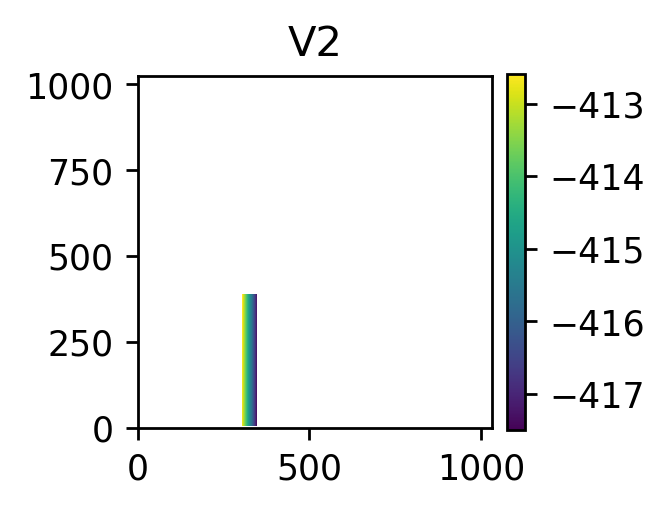

In [27]:
plt.figure(figsize=(2,2),dpi=250)
plt.title('V2')
plt.imshow(v2all,origin='lower')
plt.colorbar(fraction=0.046, pad=0.04)

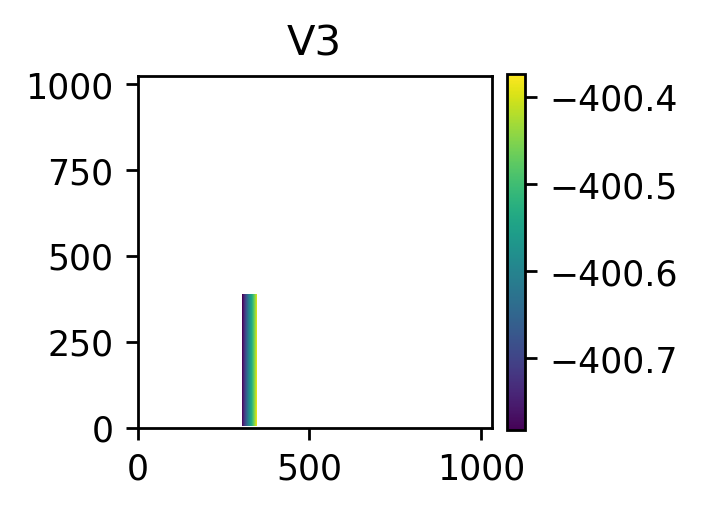

In [28]:
plt.figure(figsize=(2,2),dpi=250)
plt.title('V3')
plt.imshow(v3all,origin='lower')
plt.colorbar(fraction=0.046, pad=0.04)

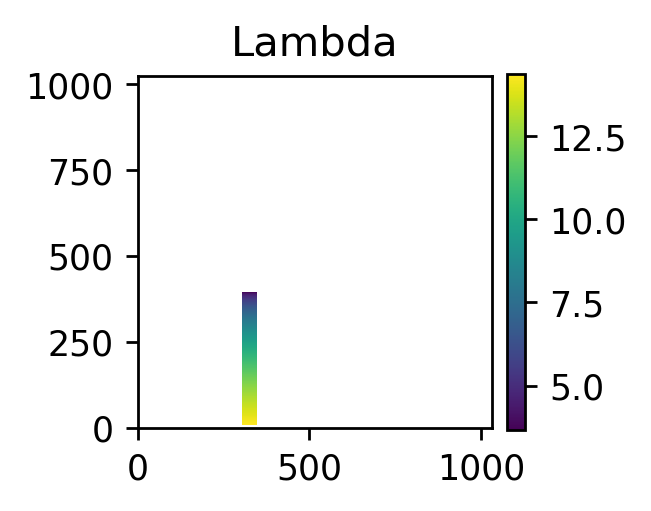

In [29]:
plt.figure(figsize=(2,2),dpi=250)
plt.title('Lambda')
plt.imshow(lamall,origin='lower')
plt.colorbar(fraction=0.046, pad=0.04)

In [30]:
# Slitless
im=datamodels.ImageModel(slitlessfile)
xrow=np.mgrid[0:im.meta.subarray.xsize]
yrow=np.mgrid[0:im.meta.subarray.ysize]
xall=mb.repmat(xrow,im.meta.subarray.ysize,1)
hdux = fits.PrimaryHDU(data=xall)
#hdux.writeto(data_dir+'cdp7test/xall.fits',overwrite=True)
yall=mb.repmat(yrow,im.meta.subarray.xsize,1)
yall=np.transpose(yall)
hduy = fits.PrimaryHDU(data=yall)
#hduy.writeto(data_dir+'cdp7test/yall.fits',overwrite=True)
v2all,v3all,lamall=im.meta.wcs.transform("detector","v2v3",xall,yall)

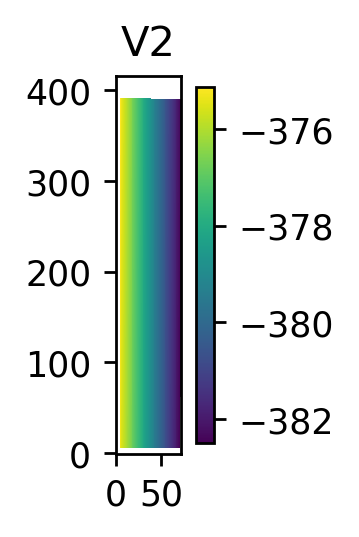

In [31]:
plt.figure(figsize=(2,2),dpi=250)
plt.title('V2')
plt.imshow(v2all,origin='lower')
plt.colorbar(fraction=0.046, pad=0.04)

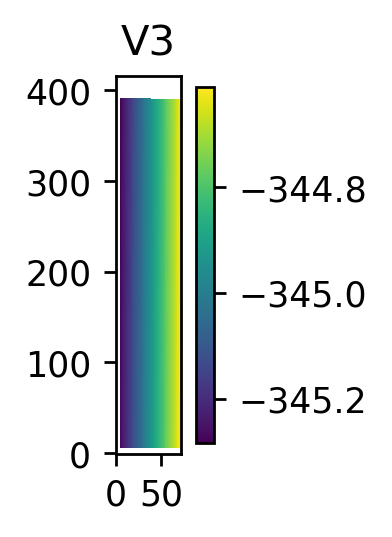

In [32]:
plt.figure(figsize=(2,2),dpi=250)
plt.title('V3')
plt.imshow(v3all,origin='lower')
plt.colorbar(fraction=0.046, pad=0.04)

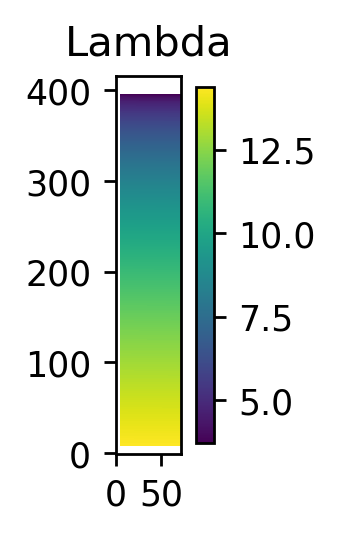

In [33]:
plt.figure(figsize=(2,2),dpi=250)
plt.title('Lambda')
plt.imshow(lamall,origin='lower')
plt.colorbar(fraction=0.046, pad=0.04)